# Similarity Check

Quickly test out different types of similarity metrics!

In [29]:
import TFO_dataset
from math import pi
from sklearn.gaussian_process import *
from inverse_modelling_tfo.data.intensity_interpolation import interpolate_exp_chunk, get_interpolate_fit_params, interpolate_exp
from inverse_modelling_tfo.data import normalize_zero_mean 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [30]:
# Load Data
train_data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_averaged_sim_data.pkl')
train_data['Intensity'] /= 20   # Normalize by the number of detectors per ring
train_data = train_data[train_data['Wave Int'] == 1.0]
train_data.head()

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a
6000,10,0.035217,1.0,5.0,26.0,0.005,0.05
6001,15,0.023046,1.0,5.0,26.0,0.005,0.05
6002,19,0.015004,1.0,5.0,26.0,0.005,0.05
6003,24,0.009408,1.0,5.0,26.0,0.005,0.05
6004,29,0.005738,1.0,5.0,26.0,0.005,0.05


In [31]:
# interpolated_trainined_data = interpolate_exp(train_data, weights=[1.0, -3])
interpolated_trainined_data = get_interpolate_fit_params(train_data, weights=[1, -2])
interpolated_trainined_data.head()

,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,alpha0,alpha1,alpha2,alpha3
0,1.0,5.0,26.0,0.0050,0.05,-3.010852,-0.147154,0.538715,-0.263730
1,1.0,5.0,26.0,0.0055,0.05,-3.191123,-0.147318,0.334169,0.108731
2,1.0,5.0,26.0,0.0060,0.05,-3.361513,-0.147630,0.141024,0.460926
3,1.0,5.0,26.0,0.0065,0.05,-3.520894,-0.148112,-0.040178,0.791609
4,1.0,5.0,26.0,0.0070,0.05,-3.668309,-0.148785,-0.208968,1.099709


In [37]:
# Sheep Data
sheep_id = 36
data = TFO_dataset.SheepData('iq_demod_optical').get(sheep_id)
# Pick a point in time
spatial_intensity = data.iloc[600 * 80].copy().to_numpy()  # 80Hz sampling freq.
spatial_intensity *=  pi * 4   # from unit area -> pi r^2 area -> match simulation
spatial_intensity *=  1/0.4   # To account for the duty cycle/ taking the first fundemental
spatial_intensity *=  100   # To account for remaining mismatch in power
SDD = [15, 30, 45, 70, 100]     # For our TFO device, in mm
wv1 = spatial_intensity[:5]
wv2 = spatial_intensity[5:]


In [45]:
def similarity_metric(simulation_alphas, patient_data):
    # Calculate intensity at given SDDs
    a0, a1, a2, a3 = simulation_alphas
    simulated_data = np.array([np.exp(a0 + a1 * x + a2 * np.sqrt(x) + a3*np.power(x, 1/3)) for x in SDD])
    patient_data = np.array(patient_data)
    metric = np.sum(np.abs(patient_data - simulated_data))
    return metric
    

In [46]:
interpolated_trainined_data['Metric'] = interpolated_trainined_data.apply(lambda X: similarity_metric([X['alpha0'], X['alpha1'], X['alpha2'], X['alpha3']], wv1), axis=1)
interpolated_trainined_data = interpolated_trainined_data.sort_values('Metric')
interpolated_trainined_data.head()

,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,alpha0,alpha1,alpha2,alpha3,Metric
4911,1.0,5.0,2.0,0.0055,0.055,-12.975335,0.387123,-15.138515,24.758836,0.000537
4903,1.0,5.0,2.0,0.0065,0.050,-12.218066,0.368218,-14.390919,23.391963,0.000537
4902,1.0,5.0,2.0,0.0060,0.050,-12.342678,0.370060,-14.482652,23.579168,0.000550
4910,1.0,5.0,2.0,0.0050,0.055,-13.102171,0.388989,-15.231653,24.949038,0.000583
3829,1.0,6.0,2.0,0.0095,0.060,-23.195580,0.562162,-23.205176,40.506346,0.000605


In [48]:
def plot_top_n_similar_curves(similarity_table : pd.DataFrame, patient_data, n: int = 10):
    plt.figure()
    for i in range(n):
        X = similarity_table.iloc[i, :]
        simulation_alphas = [X['alpha0'], X['alpha1'], X['alpha2'], X['alpha3']]
        # Logic
        a0, a1, a2, a3 = simulation_alphas
        simulated_data = np.array([np.exp(a0 + a1 * x + a2 * np.sqrt(x) + a3*np.power(x, 1/3)) for x in SDD])
        patient_data = np.array(patient_data)
        plt.plot(SDD, simulated_data, label=f'Simulation Top {i + 1}')
    
    # Plot cleanup
    plt.plot(SDD, patient_data, label='Patient Data')
    plt.legend()
    plt.yscale('log')
    return plt.gca()
    

<AxesSubplot:>

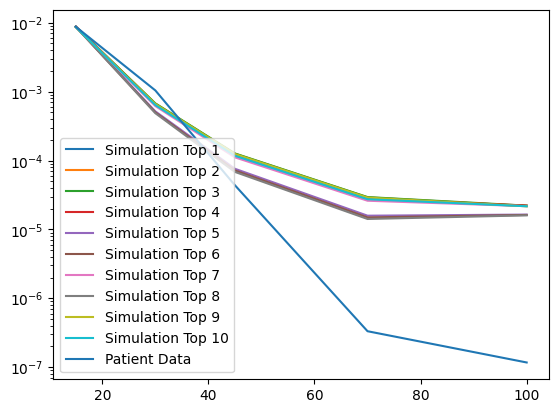

In [49]:
plot_top_n_similar_curves(interpolated_trainined_data, wv1)